In [1]:
import sys
import time
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

sns.set_theme(style="white")

# Mutation Insights

The objective of this notebook is to map mutation information to the GDSC database. In folder `knowledge_base/table_contents.md` it is described from where the Mutations and GDSC data is originating from. In the previous notebook `02_GDSC_map_GenExpr.ipynb` we mapped the GDSC data to gene-expression information. The resulting table is saved in `temp_datasets/joined_gdsc_geneexpr.pkl` which will be the starting point for this notebook.

In [2]:
!pwd
!find ../../datasets/gdsc/cell_line_genomic_data -name '*mutation*.csv' -ls

/Users/cwoest/Documents/Academics/Data_Science_UP/master_thesis/material/GNN-material
37667912  1489888 -rw-------    1 cwoest           staff            749603667 Mar 15 12:09 ../../datasets/gdsc/cell_line_genomic_data/mutations_all_20220315.csv
37707762     2376 -rw-------    1 cwoest           staff             1215200 Mar 15 11:59 ../../datasets/gdsc/cell_line_genomic_data/mutations_summary_20220315.csv


The files we will use for mapping are
- `mutations_all_20220315.csv`

In [3]:
PATH_TO_CNV_DATA = '../../datasets/gdsc/cell_line_genomic_data/'
PATH_TO_SAVE_DATA_TO = '../../datasets/gdsc/my_datasets/'

MUTATION_FILE = 'mutations_all_20220315.csv'

In [4]:
# First, we load the GDSC dataset from the previous notebook.
GDSC = pd.read_pickle(f'{PATH_TO_SAVE_DATA_TO}joined_gdsc_geneexpr.pkl')
print(GDSC.shape)
GDSC.head(3)

(446521, 922)


,DRUG_ID,CELL_LINE_NAME,AUC,CELL_ID,LN_IC50,CONC,MASTER_CELL_ID,INTENSITY,DATASET,Z_SCORE,...,MYCBP,FIS1,IFRD2,NPEPL1,CEBPD,PLEKHM1,MIF,PRAF2,LYN,POLG2
0,1,MC-CAR,0.982114,3137,2.395685,2.0,49,544404,GDSC1,-0.189576,...,8.355826,8.951680,7.205590,3.277948,3.465672,6.312806,12.112498,3.010237,8.750848,6.199366
9,1,ES3,0.984816,2366,3.140923,2.0,1342,404197,GDSC1,0.508635,...,5.995760,9.337588,7.468226,3.716270,5.363887,6.188079,12.281947,4.794624,3.588528,6.785201
27,1,ES5,0.985693,2368,3.968757,2.0,610,797378,GDSC1,1.284229,...,6.939741,8.688176,7.085349,3.688222,4.572119,6.345090,12.276166,4.114092,5.768098,7.505155


--- 

## Mutations

In this subsection we will investigate and potentially map the `mutations_all_20220315.csv` content to the `GDSC` dataset.

The following is taken from [here](https://depmap.sanger.ac.uk/documentation/datasets/):

| Dataset Type | Description | Documentation |
| :----------- | :---------- | :------------ | 
| Mutation | All sequencing data including WES, WGS & TGS used to generate mutation data for the cell line and organoid models.	 | [Mutation](https://depmap.sanger.ac.uk/documentation/datasets/mutation/) |

In [5]:
MUTATION_FILE

'mutations_all_20220315.csv'

In [6]:
start = time.time()
mutations_data = pd.read_csv(f'{PATH_TO_CNV_DATA}{MUTATION_FILE}', sep=",", header=0)
print(f"File `{MUTATION_FILE}` took {time.time()-start:.5f} seconds to import. \nShape: {mutations_data.shape}")
mutations_data.head(10)

File `mutations_all_20220315.csv` took 13.95595 seconds to import. 
Shape: (8322616, 13)


,gene_id,gene_symbol,model_id,protein_mutation,rna_mutation,cdna_mutation,cancer_driver,cancer_predisposition_variant,effect,vaf,coding,source,model_name
0,SIDG36104,SOX30,SIDM02021,-,r.?,-,False,False,intronic,0.2703,False,Sanger,HCM-SANG-1082-C15
1,SIDG37647,THG1L,SIDM02021,-,r.?,-,False,False,intronic,0.7500,False,Sanger,HCM-SANG-1082-C15
2,SIDG16920,LSM11,SIDM02021,-,r.?,-,False,False,intronic,0.6452,False,Sanger,HCM-SANG-1082-C15
3,SIDG16920,LSM11,SIDM02021,p.?,r.3207delU,c.?,False,False,3prime_UTR_variant,0.7692,False,Sanger,HCM-SANG-1082-C15
4,SIDG16920,LSM11,SIDM02021,-,r.?,-,False,False,downstream,0.3571,False,Sanger,HCM-SANG-1082-C15
5,SIDG16920,LSM11,SIDM02021,-,r.?,-,False,False,downstream,0.7692,False,Sanger,HCM-SANG-1082-C15
6,SIDG04857,CLINT1,SIDM02021,-,r.?,-,False,False,downstream,0.4400,False,Sanger,HCM-SANG-1082-C15
7,SIDG04857,CLINT1,SIDM02021,-,r.?,-,False,False,intronic,0.3478,False,Sanger,HCM-SANG-1082-C15
8,SIDG04857,CLINT1,SIDM02021,-,r.?,-,False,False,intronic,0.3077,False,Sanger,HCM-SANG-1082-C15
9,SIDG04857,CLINT1,SIDM02021,-,r.?,-,False,False,intronic,0.3571,False,Sanger,HCM-SANG-1082-C15


In [7]:
start = time.time()
mutations_summary = pd.read_csv(f'{PATH_TO_CNV_DATA}mutations_summary_20220315.csv', sep=",", header=0)
print(f"File `mutations_summary_20220315.csv` took {time.time()-start:.5f} seconds to import. \nShape: {mutations_summary.shape}")
mutations_summary.head(10)

File `mutations_summary_20220315.csv` took 0.10731 seconds to import. 
Shape: (11609, 13)


,gene_id,gene_symbol,model_id,protein_mutation,rna_mutation,cdna_mutation,cancer_driver,cancer_predisposition_variant,effect,vaf,coding,source,model_name
0,SIDG13960,KRAS,SIDM01279,p.G12A,r.99g>c,c.35G>C,True,False,missense,0.5952,True,Sanger,HCM-SANG-0269-C18
1,SIDG01214,APC,SIDM01279,p.K1462*,r.4440a>u,c.4384A>T,True,False,nonsense,0.6757,True,Sanger,HCM-SANG-0269-C18
2,SIDG00920,AMER1,SIDM01279,p.W571*,r.1985g>a,c.1712G>A,True,False,nonsense,0.9714,True,Sanger,HCM-SANG-0269-C18
3,SIDG01764,ATM,SIDM01954,p.R1875*,r.6008c>u,c.5623C>T,True,False,nonsense,0.5000,True,Sanger,HCM-SANG-0537-C18
4,SIDG13960,KRAS,SIDM01954,p.G12S,r.98g>a,c.34G>A,True,False,missense,1.0000,True,Sanger,HCM-SANG-0537-C18
5,SIDG38363,TP53,SIDM01954,p.W91*,r.462g>a,c.272G>A,True,False,nonsense,1.0000,True,Sanger,HCM-SANG-0537-C18
6,SIDG24670,PIK3CA,SIDM01954,p.P104R,r.468c>g,c.311C>G,True,False,missense,0.4048,True,Sanger,HCM-SANG-0537-C18
7,SIDG38363,TP53,SIDM01277,p.E287_E294delENLRKKGE,r.1048_1071del24,c.858_881del24,True,False,inframe,1.0000,True,Sanger,HCM-SANG-0307-C15
8,SIDG16764,LRP1B,SIDM01277,p.T4475fs*3,r.14395_14396insa,c.13423_13424insA,True,False,frameshift,0.4872,True,Sanger,HCM-SANG-0307-C15
9,SIDG35070,SMAD4,SIDM01953,p.P293fs*10,r.1415_1428delCCUAUGCCGCCCCA,c.877_890delCCTATGCCGCCCCA,True,False,frameshift,1.0000,True,Sanger,HCM-SANG-0519-C20


In the mutations dataset we only have the `gene_symbol` but not the cell line name specifically as a column. However, we are given the `model_id`. This `model_id` can be mapped to the GDSC database to the column `SANGER_MODEL_ID` and from there the `CELL_LINE_NAME` can be infered. Thus, the steps to take are as follows: 
- [ ] Proof that the `SANGER_MODEL_ID` can 
  - [ ] be mapped to the `model_id`
  - [ ] has always one `CELL_LINE_NAME` (should be a 1-1 relationship, otherwise infering is not possible)
- [ ] Join the GDSC onto the mutations table and therefore infer the corresponding `CELL_LINE_NAME` per row (if given).

In [8]:
# Get the full GDSC database.

# GDSC IC50s.
gdsc1_ic50s = pd.read_excel(f'../../datasets/gdsc/screening_data/GDSC1_fitted_dose_response_25Feb20.xlsx', header=0)
gdsc2_ic50s = pd.read_excel(f'../../datasets/gdsc/screening_data/GDSC2_fitted_dose_response_25Feb20.xlsx', header=0)
gdsc_ic50s_join = pd.concat([gdsc1_ic50s, gdsc2_ic50s], ignore_index=True)

# GDSC raw. 
gdsc1_raw = pd.read_csv('../../datasets/gdsc/screening_data/GDSC1_public_raw_data_25Feb20.csv', header=0)
gdsc2_raw = pd.read_csv('../../datasets/gdsc/screening_data/GDSC2_public_raw_data_25Feb20.csv', header=0)
gdsc_raw_join = pd.concat([gdsc1_raw, gdsc2_raw], ignore_index=True)

# Join raw and ic50's.
cols_to_join_on = ['CELL_LINE_NAME', 'DRUG_ID']
gdsc_ic50_raw_join = gdsc_ic50s_join.merge(gdsc_raw_join,
                                           on=cols_to_join_on,
                                           how='left',
                                           suffixes=['_ic50', '_raw'])
print(gdsc_ic50_raw_join.shape)
gdsc_ic50_raw_join.head(5)

/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_69549/3599118786.py:9: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  gdsc1_raw = pd.read_csv('../../datasets/gdsc/screening_data/GDSC1_public_raw_data_25Feb20.csv', header=0)


(5707271, 35)


,DATASET,NLME_RESULT_ID,NLME_CURVE_ID,COSMIC_ID_ic50,CELL_LINE_NAME,SANGER_MODEL_ID,TCGA_DESC,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,...,MASTER_CELL_ID,COSMIC_ID_raw,SEEDING_DENSITY,DRUGSET_ID,ASSAY,DURATION,POSITION,TAG,CONC,INTENSITY
0,GDSC1,281,12974350,683665,MC-CAR,SIDM00636,MM,1,Erlotinib,EGFR,...,49,683665,NaN,410_a_9,s,3.0,14,L1-D1-S,2.000,544404
1,GDSC1,281,12974350,683665,MC-CAR,SIDM00636,MM,1,Erlotinib,EGFR,...,49,683665,NaN,410_a_9,s,3.0,15,L1-D2-S,1.000,599897
2,GDSC1,281,12974350,683665,MC-CAR,SIDM00636,MM,1,Erlotinib,EGFR,...,49,683665,NaN,410_a_9,s,3.0,16,L1-D3-S,0.500,587627
3,GDSC1,281,12974350,683665,MC-CAR,SIDM00636,MM,1,Erlotinib,EGFR,...,49,683665,NaN,410_a_9,s,3.0,17,L1-D4-S,0.250,597272
4,GDSC1,281,12974350,683665,MC-CAR,SIDM00636,MM,1,Erlotinib,EGFR,...,49,683665,NaN,410_a_9,s,3.0,18,L1-D5-S,0.125,594490


In [44]:
# Proof that the SANGER_MODEL_ID can be mapped to the model_id.
test = gdsc_ic50_raw_join.merge(mutations_summary,
                                right_on='model_id',
                                left_on='SANGER_MODEL_ID',
                                how='inner',
                                suffixes=['_gdsc', '_mut'])
print(f"""
    GDSC : {gdsc_ic50_raw_join.shape}
    mut  : {mutations_summary.shape}

    inner : {test.shape}
""")


    GDSC : (5707271, 35)
    mut  : (11609, 13)

    inner : (53359867, 48)



In [63]:
sangers = set(np.unique(gdsc_ic50_raw_join.SANGER_MODEL_ID)) 
model_ids = set(np.unique(mutations_summary.model_id))
print(f"""Unique
    SANGER_MDEL_ID's : {len(sangers):5.0f} (GDSC table)
    model_id's       : {len(model_ids):5.0f} (Mutations table)
""")

unequal = len(list(sangers - model_ids))
equal = len(sangers) - unequal
print(f"""
There are {unequal} ({100*unequal/len(sangers):2.2f}%) SANGER_MODEL_ID's which are in the GDSC database 
    but not model_id's in the mutations table.
The remaining {equal} ({100*equal/len(sangers):2.2f}%) SANGER_MODEL_ID's are both, in the GDSC database 
    as well as model_id's in the mutations table.
""")

Unique
    SANGER_MDEL_ID's :   988 (GDSC table)
    model_id's       :  1346 (Mutations table)


There are 21 (2.13%) SANGER_MODEL_ID's which are in the GDSC database 
    but not model_id's in the mutations table.
The remaining 967 (97.87%) SANGER_MODEL_ID's are both, in the GDSC database 
    as well as model_id's in the mutations table.



Thus, we can conclude that the `SANGER_MODEL_ID` from the GDSC database can be mapped to the `model_id` from the mutations table.

Out of the equal `SANGER_MODEL_ID`'s and `model_id`'s respectively, check how much each ID is given per dataset.

In [66]:
# Count per SANGER_MODEL_ID in the GDSC table.
sanger_ids_count_gdsc = gdsc_ic50_raw_join.groupby(['SANGER_MODEL_ID']).size()

# Count per model_id in the mutations table.
model_ids_count_mut = mutations_summary.groupby(['model_id']).size()


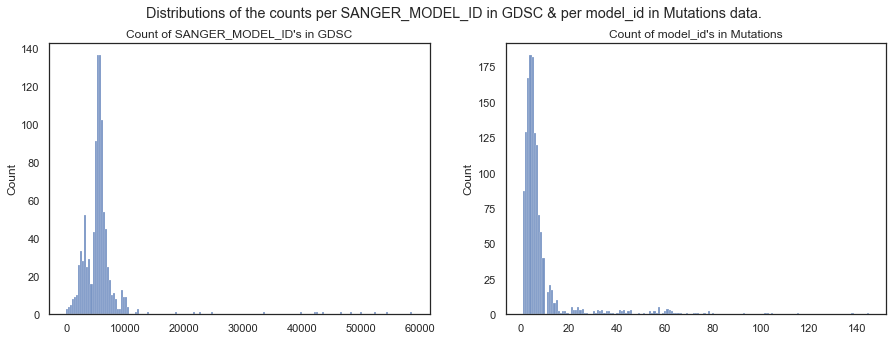

In [74]:
figure, axs = plt.subplots(1, 2, figsize=(15, 5))
figure.suptitle(f"Distributions of the counts per SANGER_MODEL_ID in GDSC & per model_id in Mutations data.")

sns.histplot(sanger_ids_count_gdsc, ax=axs[0]);
axs[0].set_title("Count of SANGER_MODEL_ID's in GDSC");
sns.histplot(model_ids_count_mut, ax=axs[1]);
axs[1].set_title("Count of model_id's in Mutations");


## Map Gene Expression to Mutations

As in notebook `02_GDSC_map_GeneExpr.ipynb` we saved the sparsed gene expression data to `geneexpr_sparse.pkl`. We will use this tables index column `Sample Name` to map it to the `gene_symbol` column of the mutations table.

In [11]:
# Read sparsed gene expression table.
gene_expr_sparse = pd.read_pickle(f'{PATH_TO_SAVE_DATA_TO}geneexpr_sparse.pkl')
print(gene_expr_sparse.shape)
gene_expr_sparse.head(3)

(1018, 908)


Sample Name,TSPAN6,SCYL3,BAD,LAP3,SNX11,CASP10,CFLAR,FKBP4,RBM6,SLC25A13,...,MYCBP,FIS1,IFRD2,NPEPL1,CEBPD,PLEKHM1,MIF,PRAF2,LYN,POLG2
CAL-120,7.632023,3.614794,7.458409,6.453926,4.767457,2.831262,5.463531,8.654218,5.365098,5.682413,...,8.217182,9.344897,8.175046,3.933749,9.340292,6.167946,11.893872,5.060852,5.892532,6.476232
DMS-114,7.548671,4.066887,7.479327,6.742826,5.246301,2.788942,4.662621,9.530892,5.271282,4.724554,...,8.128025,9.122008,7.564726,3.577621,6.056126,5.271099,11.841300,6.515567,4.580184,6.772732
CAL-51,8.712338,3.956230,7.419672,5.655691,4.645800,3.191751,5.519212,7.612684,5.354469,8.167217,...,7.265206,9.567052,7.774788,4.169622,10.182601,5.784561,12.272137,4.815762,6.482469,6.031281


The gene expression table contains 
- $1018$ `CELL_LINE_NAME` (rows)
- $908$ `GENE_SYMBOL` (rows)

In [24]:
gene_symbols_expr = set(np.unique(list(gene_expr_sparse.columns)))
gene_symbols_mut = set(np.unique(mutations_summary.gene_symbol))

print(f"""
    Gene symbols in ...
        ... Gene Expression table : {len(gene_symbols_expr)}
        ... Mutations       table : {len(gene_symbols_mut)}
""")


    Gene symbols in ...
        ... Gene Expression table : 908
        ... Mutations       table : 611



In [33]:
# Transpose the mutations table such that the GENE_SYMBOLs are the columns and the CELL_LINE_NAMES are the indexes of the rows.
# Copy mutations dataset without GENE_ID column and transpose.
mut_v2 = gene_expr_sparse.iloc[:, :].copy().T
mut_v2
# Ignore the first row and make the GEN_SYMBOL names as the new columns. Also make the previous CELL_LINE_NAMES columns as the new row index.
#mut_v2 = mut_v2.rename(columns=mut_v2.iloc[0]).drop(mut_v2.index[0])
#print(mut_v2.shape)
#mut_v2.head(3)

,CAL-120,DMS-114,CAL-51,H2869,H290,A2058,CESS,H2803,H2722,HCC1419,...,LB831-BLC,HC-1,Jurkat,MOG-G-UVW,unknown_cosmic_1659787,JIMT-1,PEO1,PL4,TT,unknown_cosmic_905954.1
Sample Name,,,,,,,,,,,,,,,,,,,,,
TSPAN6,7.632023,7.548671,8.712338,7.797142,7.729268,7.074533,3.285198,6.961606,5.943046,3.455951,...,7.105637,3.236503,3.038892,8.373223,6.932178,8.441628,8.422922,8.089255,3.112333,7.153127
SCYL3,3.614794,4.066887,3.956230,4.063701,4.341500,4.270903,5.968168,3.715033,3.848112,5.560883,...,3.696835,4.624013,4.348524,3.858121,3.947561,4.425849,3.550390,4.443337,4.266828,4.100493
BAD,7.458409,7.479327,7.419672,7.731137,6.998981,6.550210,6.354063,7.940838,7.488690,8.771958,...,7.147962,6.478426,6.919537,6.801096,7.153122,7.234464,7.525257,6.066356,8.185968,4.967268
LAP3,6.453926,6.742826,5.655691,5.259367,4.611395,6.930777,8.560707,7.815915,4.765141,7.593677,...,5.383810,8.591164,6.208059,6.715130,6.530806,5.759933,7.810126,7.182077,5.663629,6.539451
SNX11,4.767457,5.246301,4.645800,4.558836,5.456692,5.099542,7.574348,4.879785,4.842966,7.809379,...,4.755084,6.761799,5.034195,4.958603,4.629068,4.982202,5.037259,4.611973,4.800284,4.967207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PLEKHM1,6.167946,5.271099,5.784561,7.587263,6.479184,5.700915,6.617353,7.687708,7.944761,5.998456,...,6.714959,6.368537,8.252268,6.436644,6.436742,5.551436,5.634834,7.083564,5.776658,6.306988
MIF,11.893872,11.841300,12.272137,12.000410,11.867211,12.621575,11.825283,12.040673,11.509597,12.777104,...,12.286071,12.572595,12.254136,12.588238,12.366026,12.153612,12.265099,11.919307,12.762295,12.985613
PRAF2,5.060852,6.515567,4.815762,4.544863,6.071288,4.777850,3.455981,4.764558,6.151629,3.612488,...,5.314914,2.943601,4.723601,5.769965,5.070665,3.443244,3.293080,2.978125,5.125786,4.404205


In [34]:
mut_v2.index

Index(['TSPAN6', 'SCYL3', 'BAD', 'LAP3', 'SNX11', 'CASP10', 'CFLAR', 'FKBP4',
       'RBM6', 'SLC25A13',
       ...
       'MYCBP', 'FIS1', 'IFRD2', 'NPEPL1', 'CEBPD', 'PLEKHM1', 'MIF', 'PRAF2',
       'LYN', 'POLG2'],
      dtype='object', name='Sample Name', length=908)

In [25]:
# Check if the SANGER_MODEL_ID has 1-1 relationship with the CELL_LINE_NAME.

test = gdsc_ic50_raw_join.merge(mutations_summary,
                                right_on='model_id',
                                left_on='SANGER_MODEL_ID',
                                how='left',
                                suffixes=['_gdsc', '_mut'])
print(f"""
    GDSC : {gdsc_ic50_raw_join.shape}
    mut  : {mutations_summary.shape}

    inner : {test.shape}
""")


    GDSC : (5707271, 35)
    mut  : (11609, 13)

    inner : (53503481, 48)



In [33]:
gdsc_cell_line_names = np.unique(GDSC.CELL_LINE_NAME.values)

In [38]:
len(np.unique(mutations_data.model_id.values))

1385

In [41]:
len(np.unique(GDSC.CELL_LINE_NAME.values))

988

In [25]:
gdsc_cell_line_names[:10]

array(['201T', '22RV1', '23132-87', '42-MG-BA', '451Lu', '5637', '639-V',
       '647-V', '697', '769-P'], dtype=object)

In [32]:
'TP53' in gdsc_cell_line_names

False